In [1]:
import tensorflow as tf
from tensorflow import keras

from keras.layers import Conv1D , Dropout , Flatten , MaxPooling1D, Dense, Input, BatchNormalization
from keras.layers.core import Lambda
from keras.models import Model , load_model

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import random
import h5py
from IPython.display import Image

Using TensorFlow backend.


## Carga y distribución de datos

In [2]:
# Cargamos los datos
path_local_data = '/home/anell/Desktop/Bovy/AnellExercises/Fits_files'
#path_local_data = '/home/bapanes/Research-Now/local/astronn-local/apo-gaia/'

with h5py.File(f'{path_local_data}/apogeedr14_gaiadr2_with_spectrum_probando_rendimiento_2.h5','r') as F:  
    parallax = np.array(F['parallax'])
    parallax_error = np.array(F['parallax_err'])
    spectra = np.array(F['spectra'])
    Kmag = np.array(F['corrected_magnitude_K'])
    bp_rp = np.array(F['bp_rp'])
    Gmag = np.array(F['phot_g_mean_mag'])
    teff = np.array(F['NN_teff'])
    apogee_id = np.array(F['APOGEE_ID'])
    snr = np.array(F['SNR'])
    fe_h = np.array(F['Fe/H'])
    path_spectra = np.array(F['Path_spectra'])
    Logg = np.array(F['NN_Logg'])

In [3]:
parallax.shape , spectra.shape , Kmag.shape

((60986,), (60986, 7514), (60986,))

In [4]:
#Establecemos las variables que entrarán a la red y corregimos sus dimensiones
X = np.expand_dims(spectra, axis = 2)
Y = np.expand_dims(parallax, axis = 1)
K_mag = np.expand_dims(Kmag, axis = 1)

# Normalizamos Gmag , el color (G_bp - G_rp) y teff
Gmag_std = np.std(Gmag)
Gmag_mean = np.mean(Gmag)
Gmag_norm = (Gmag - Gmag_mean) / Gmag_std

bp_rp_std = np.std(bp_rp)
bp_rp_mean = np.mean(bp_rp)
bp_rp_norm = (bp_rp - bp_rp_mean) / bp_rp_std

teff_std = np.std(teff)
teff_mean = np.mean(teff)
teff_norm = (teff - teff_mean) / teff_std

G_mag = np.expand_dims(Gmag_norm, axis=1)
Bp_Rp = np.expand_dims(bp_rp_norm, axis=1)
Teff = np.expand_dims(teff_norm, axis=1)
teff_not_norm = np.expand_dims(teff, axis=1)
G_mag_not_norm = np.expand_dims(Gmag, axis=1)
Log_g= np.expand_dims(Logg, axis=1)
G_BP_RP = np.expand_dims(bp_rp, axis=1)

X_offset = np.concatenate((G_mag, Bp_Rp , Teff), axis = 1) 

In [5]:
print(X.shape , Y.shape, K_mag.shape, X_offset.shape)

(60986, 7514, 1) (60986, 1) (60986, 1) (60986, 3)


#### SNR cut

In [6]:
high_snr_idx = []
low_snr_idx = []

for i in range(len(snr)):
    if snr[i] >= 200:           
        high_snr_idx.append(i)
    else:
        low_snr_idx.append(i)

random.seed(10)
random.shuffle(high_snr_idx)
random.seed(60)
random.shuffle(low_snr_idx)

#### Estos valores pueden ser comparados con Bovy train-test separation, 

Apart from taht we should be more clear about data preparation and evaluation

get consistent and repeatable accuracy using train and validation approach <br>
undestand the process of validation (draft about probability_distributions) <br> 
check the precision on the test data using baseline separation <br>
compute learning curve, following Fig 1. of Nguyen et. al.<br>
try with percentual mse, such that low and high parallax values weight the same <br>

initially we can consider SNR>200 for train-valid and SNR<200 for test <br>
understand why it is possible to make this separation and hope for consistent results <br>

compare to Bovy using this data separation, using global precision and learning curve<br>

How well are we doing with respect to Bovy?

In [7]:
#Image("/home/bapanes/Research-Now/TesisAnell/Figures/learning_curve_genoma.png")
#Image("learning_curve_genoma.png")

In [8]:
print("SNR>200: %d, else: %d"%(len(high_snr_idx), len(low_snr_idx)))

SNR>200: 27721, else: 33265


### Diseño Experimental:

Consideraré train (0.8) y valid (0.2)

train_val_1 $\rightarrow$  177 (train) + 44 (valid) = 221

train_val_2 $\rightarrow$  400 (train) + 100 (valid) = 500

train_val_3 $\rightarrow$  800 (train) + 200 (valid) = 1000

train_val_4 $\rightarrow$  2400 (train) + 600 (valid) = 3000

train_val_5 $\rightarrow$  6400 (train) + 1600 (valid) = 8000

train_val_6 $\rightarrow$  12000 (train) + 3000 (valid) = 15000

train_val_7 $\rightarrow$  22177 (train) + 5594 (valid) = 27721

test $\rightarrow$ 33265

In [9]:
X_high_snr = X[high_snr_idx]
Y_high_snr = Y[high_snr_idx]
K_mag_high_snr = K_mag[high_snr_idx]
X_offset_high_snr = X_offset[high_snr_idx]
#teff_not_norm_high_snr = teff_not_norm[high_snr_idx]

X_low_snr = X[low_snr_idx]
Y_low_snr = Y[low_snr_idx]
K_mag_low_snr = K_mag[low_snr_idx]
X_offset_low_snr = X_offset[low_snr_idx]
#teff_not_norm_low_snr = teff_not_norm[low_snr_idx]

In [10]:
X_train_val_1 = X_high_snr[:221]
Y_train_val_1 = Y_high_snr[:221]
K_mag_train_val_1 = K_mag_high_snr[:221]
X_offset_train_val_1 = X_offset_high_snr[:221]

X_train_val_2 = X_high_snr[221:721]
Y_train_val_2 = Y_high_snr[221:721]
K_mag_train_val_2 = K_mag_high_snr[221:721]
X_offset_train_val_2 = X_offset_high_snr[221:721]

X_train_val_1_2 = X_high_snr[:721]
Y_train_val_1_2 = Y_high_snr[:721]
K_mag_train_val_1_2 = K_mag_high_snr[:721]
X_offset_train_val_1_2 = X_offset_high_snr[:721]

X_train_val_3 = X_high_snr[721:1721]
Y_train_val_3 = Y_high_snr[721:1721]
K_mag_train_val_3 = K_mag_high_snr[721:1721]
X_offset_train_val_3 = X_offset_high_snr[721:1721]

X_train_val_4 = X_high_snr[1721:4721]
Y_train_val_4 = Y_high_snr[1721:4721]
K_mag_train_val_4 = K_mag_high_snr[1721:4721]
X_offset_train_val_4 = X_offset_high_snr[1721:4721]

X_train_val_5 = X_high_snr[4721:12721]
Y_train_val_5 = Y_high_snr[4721:12721]
K_mag_train_val_5 = K_mag_high_snr[4721:12721]
X_offset_train_val_5 = X_offset_high_snr[4721:12721]

X_train_val_6 = X_high_snr[12721:]
Y_train_val_6 = Y_high_snr[12721:]
K_mag_train_val_6 = K_mag_high_snr[12721:]
X_offset_train_val_6 = X_offset_high_snr[12721:]

X_train_val_7 = X_high_snr
Y_train_val_7 = Y_high_snr
K_mag_train_val_7 = K_mag_high_snr
X_offset_train_val_7 = X_offset_high_snr

X_test = X_low_snr
Y_test = Y_low_snr
K_mag_test = K_mag_low_snr
X_offset_test = X_offset_low_snr
snr_test = snr[low_snr_idx]
teff_test = teff_not_norm[low_snr_idx]
G_mag_test = G_mag_not_norm[low_snr_idx]
logg_test = Log_g[low_snr_idx]
G_bp_rp_test = G_BP_RP[low_snr_idx]

In [11]:
print(Y_train_val_1.shape , Y_train_val_2.shape , Y_train_val_3.shape, Y_train_val_4.shape , 
      Y_train_val_5.shape,Y_train_val_6.shape ,Y_train_val_7.shape , Y_test.shape)

(221, 1) (500, 1) (1000, 1) (3000, 1) (8000, 1) (15000, 1) (27721, 1) (33265, 1)


#### Carga de modelos

In [12]:
path_local_models = '/home/anell/Desktop/Bovy/AnellExercises/Good_Models/'

#No consideraré los modelos 1 y 2 porque se entrenaron con muy pocos datos

model_3 = load_model(f'{path_local_models}/Modelo_1_200epoch_D3_ReplicaBovy.h5',custom_objects={'tf': tf}) #1000
model_4 = load_model(f'{path_local_models}/Modelo_1_200epoch_D4_ReplicaBovy.h5',custom_objects={'tf': tf}) #3000
model_5 = load_model(f'{path_local_models}/Modelo_1_200epoch_D5_ReplicaBovy.h5',custom_objects={'tf': tf}) #8000
model_6 = load_model(f'{path_local_models}/Modelo_1_200epoch_D6_ReplicaBovy.h5',custom_objects={'tf': tf}) #15000
model_7 = load_model(f'{path_local_models}/Modelo_1_200epoch_D7_ReplicaBovy.h5',custom_objects={'tf': tf}) #27771

#### Separación en bins del set de testeo

In [13]:
snr_0_20 = []
snr_20_40 = []
snr_0_40 = []
snr_40_60 = []
snr_60_80 = []
snr_80_100 = []
snr_100_120 = []
snr_120_140 = []
snr_140_160 = []
snr_160_180 = []
snr_180_200 = []

for i in range(len(snr_test)):
    if snr_test[i] <= 20:
        snr_0_20.append(i)
        snr_0_40.append(i)
    elif 20 < snr_test[i] <= 40:
        snr_20_40.append(i)
        snr_0_40.append(i)
    elif 40 < snr_test[i] <= 60:
        snr_40_60.append(i)
    elif 60 < snr_test[i] <= 80:
        snr_60_80.append(i)
    elif 80 < snr_test[i] <= 100:
        snr_80_100.append(i)
    elif 100 < snr_test[i] <= 120:
        snr_100_120.append(i)
    elif 120 < snr_test[i] <= 140:
        snr_120_140.append(i)
    elif 140 < snr_test[i] <= 160:
        snr_140_160.append(i)
    elif 160 < snr_test[i] <= 180:
        snr_160_180.append(i)
    else:
        snr_180_200.append(i)

print(len(snr_0_20),len(snr_20_40),len(snr_40_60),len(snr_60_80),len(snr_80_100),len(snr_100_120),len(snr_120_140),
     len(snr_140_160),len(snr_160_180),len(snr_180_200))

134 518 1113 2012 4206 6057 6072 5204 4307 3642


In [14]:
X_test_snr_0_20 = X_test[snr_0_20]
Y_test_snr_0_20 = Y_test[snr_0_20]
K_mag_test_snr_0_20 = K_mag_test[snr_0_20]
X_offset_test_snr_0_20 = X_offset_test[snr_0_20]
teff_test_snr_0_20 = teff_test[snr_0_20]
G_mag_test_snr_0_20 = G_mag_test[snr_0_20]
logg_test_snr_0_20 = logg_test[snr_0_20]
G_bp_rp_test_snr_0_20 = G_bp_rp_test[snr_0_20]

X_test_snr_20_40 = X_test[snr_20_40]
Y_test_snr_20_40 = Y_test[snr_20_40]
K_mag_test_snr_20_40 = K_mag_test[snr_20_40]
X_offset_test_snr_20_40 = X_offset_test[snr_20_40]
teff_test_snr_20_40 = teff_test[snr_20_40]
G_mag_test_snr_20_40 = G_mag_test[snr_20_40]
logg_test_snr_20_40 = logg_test[snr_20_40]
G_bp_rp_test_snr_20_40 = G_bp_rp_test[snr_20_40]

X_test_snr_0_40 = X_test[snr_0_40]
Y_test_snr_0_40 = Y_test[snr_0_40]
K_mag_test_snr_0_40 = K_mag_test[snr_0_40]
X_offset_test_snr_0_40 = X_offset_test[snr_0_40]
teff_test_snr_0_40 = teff_test[snr_0_40]
G_mag_test_snr_0_40 = G_mag_test[snr_0_40]
logg_test_snr_0_40 = logg_test[snr_0_40]
G_bp_rp_test_snr_0_40 = G_bp_rp_test[snr_0_40]

X_test_snr_40_60 = X_test[snr_40_60]
Y_test_snr_40_60 = Y_test[snr_40_60]
K_mag_test_snr_40_60 = K_mag_test[snr_40_60]
X_offset_test_snr_40_60 = X_offset_test[snr_40_60]
teff_test_snr_40_60 = teff_test[snr_40_60]
G_mag_test_snr_40_60 = G_mag_test[snr_40_60]
logg_test_snr_40_60 = logg_test[snr_40_60]
G_bp_rp_test_snr_40_60 = G_bp_rp_test[snr_40_60]

X_test_snr_60_80 = X_test[snr_60_80]
Y_test_snr_60_80 = Y_test[snr_60_80]
K_mag_test_snr_60_80 = K_mag_test[snr_60_80]
X_offset_test_snr_60_80 = X_offset_test[snr_60_80]
teff_test_snr_60_80 = teff_test[snr_60_80]
G_mag_test_snr_60_80 = G_mag_test[snr_60_80]
logg_test_snr_60_80 = logg_test[snr_60_80]
G_bp_rp_test_snr_60_80 = G_bp_rp_test[snr_60_80]

X_test_snr_80_100 = X_test[snr_80_100]
Y_test_snr_80_100 = Y_test[snr_80_100]
K_mag_test_snr_80_100 = K_mag_test[snr_80_100]
X_offset_test_snr_80_100 = X_offset_test[snr_80_100]
teff_test_snr_80_100 = teff_test[snr_80_100]
G_mag_test_snr_80_100 = G_mag_test[snr_80_100]
logg_test_snr_80_100 = logg_test[snr_80_100]
G_bp_rp_test_snr_80_100 = G_bp_rp_test[snr_80_100]

X_test_snr_100_120 = X_test[snr_100_120]
Y_test_snr_100_120 = Y_test[snr_100_120]
K_mag_test_snr_100_120 = K_mag_test[snr_100_120]
X_offset_test_snr_100_120 = X_offset_test[snr_100_120]
teff_test_snr_100_120 = teff_test[snr_100_120]
G_mag_test_snr_100_120 = G_mag_test[snr_100_120]
logg_test_snr_100_120 = logg_test[snr_100_120]
G_bp_rp_test_snr_100_120 = G_bp_rp_test[snr_100_120]

X_test_snr_120_140 = X_test[snr_120_140]
Y_test_snr_120_140 = Y_test[snr_120_140]
K_mag_test_snr_120_140 = K_mag_test[snr_120_140]
X_offset_test_snr_120_140 = X_offset_test[snr_120_140]
teff_test_snr_120_140 = teff_test[snr_120_140]
G_mag_test_snr_120_140 = G_mag_test[snr_120_140]
logg_test_snr_120_140 = logg_test[snr_120_140]
G_bp_rp_test_snr_120_140 = G_bp_rp_test[snr_120_140]

X_test_snr_140_160 = X_test[snr_140_160]
Y_test_snr_140_160 = Y_test[snr_140_160]
K_mag_test_snr_140_160 = K_mag_test[snr_140_160]
X_offset_test_snr_140_160 = X_offset_test[snr_140_160]
teff_test_snr_140_160 = teff_test[snr_140_160]
G_mag_test_snr_140_160 = G_mag_test[snr_140_160]
logg_test_snr_140_160 = logg_test[snr_140_160]
G_bp_rp_test_snr_140_160 = G_bp_rp_test[snr_140_160]

X_test_snr_160_180 = X_test[snr_160_180]
Y_test_snr_160_180 = Y_test[snr_160_180]
K_mag_test_snr_160_180 = K_mag_test[snr_160_180]
X_offset_test_snr_160_180 = X_offset_test[snr_160_180]
teff_test_snr_160_180 = teff_test[snr_160_180]
G_mag_test_snr_160_180 = G_mag_test[snr_160_180]
logg_test_snr_160_180 = logg_test[snr_160_180]
G_bp_rp_test_snr_160_180 = G_bp_rp_test[snr_160_180]

X_test_snr_180_200 = X_test[snr_180_200]
Y_test_snr_180_200 = Y_test[snr_180_200]
K_mag_test_snr_180_200 = K_mag_test[snr_180_200]
X_offset_test_snr_180_200 = X_offset_test[snr_180_200]
teff_test_snr_180_200 = teff_test[snr_180_200]
G_mag_test_snr_180_200= G_mag_test[snr_180_200]
logg_test_snr_180_200= logg_test[snr_180_200]
G_bp_rp_test_snr_180_200 = G_bp_rp_test[snr_180_200]

In [15]:
print( Y_test_snr_0_20.shape, Y_test_snr_20_40.shape, Y_test_snr_40_60.shape, Y_test_snr_60_80.shape, 
      Y_test_snr_80_100.shape, Y_test_snr_100_120.shape, Y_test_snr_120_140.shape, Y_test_snr_140_160.shape,
      Y_test_snr_160_180.shape , Y_test_snr_180_200.shape)

(134, 1) (518, 1) (1113, 1) (2012, 1) (4206, 1) (6057, 1) (6072, 1) (5204, 1) (4307, 1) (3642, 1)


### Evaluación Inicial

In [19]:
Y_test_hat_m7 = model_7.predict([X_test,K_mag_test,X_offset_test])
Y_test_hat_m6 = model_6.predict([X_test,K_mag_test,X_offset_test])
Y_test_hat_m5 = model_5.predict([X_test,K_mag_test,X_offset_test])
Y_test_hat_m4 = model_4.predict([X_test,K_mag_test,X_offset_test])
Y_test_hat_m3 = model_3.predict([X_test,K_mag_test,X_offset_test])

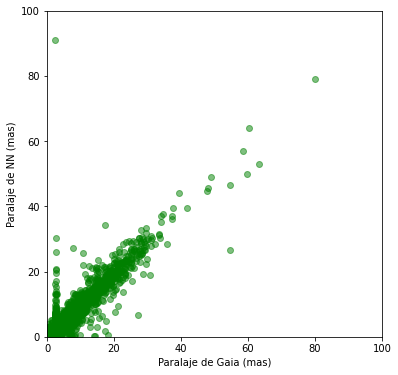

In [20]:
plt.figure(figsize = (6,6))
plt_test = plt.scatter(Y_test, Y_test_hat_m7, c="g", alpha=0.5)
#plt_train = plt.scatter(Y_train_val_7, Y_train_val_7_hat_m7, c="r", alpha=0.5)

#No reportar MSE!!! en ese caso es mejor reportar residuos 
#plt.legend((plt_train , plt_test),
#           (f'mse set de validación: {0.33}',f'mse set de testeo: {round(mse_test_m7, 2)}'),
#           scatterpoints=1,
#           loc='lower right',
#           ncol=1,
#           fontsize=10)


plt.xlabel("Paralaje de Gaia (mas)")
plt.ylabel("Paralaje de NN (mas)")

plt.ylim(0,100)
plt.xlim(0,100)
plt.show()

### Distribución de errores residuales

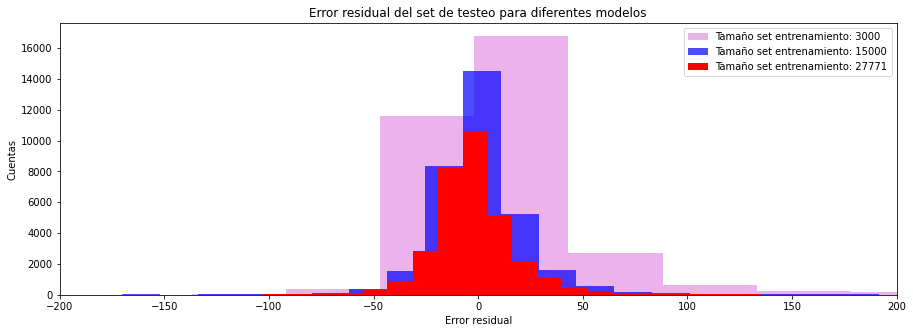

In [21]:
error_residual_test_m7 = (Y_test_hat_m7 - Y_test) / Y_test *100
error_residual_test_m6 = (Y_test_hat_m6 - Y_test) / Y_test *100
error_residual_test_m5 = (Y_test_hat_m5 - Y_test) / Y_test *100
error_residual_test_m4 = (Y_test_hat_m4 - Y_test) / Y_test *100
error_residual_test_m3 = (Y_test_hat_m3 - Y_test) / Y_test *100

bins = np.linspace(0, 50, 10) 

plt.figure(figsize = (15,5))

#plt.subplot(1,2,1)
plt.hist(error_residual_test_m4, bins=10000, alpha=0.3 , color="m",label = "Tamaño set entrenamiento: 3000")
#plt.hist(error_residual_test_m5, bins=10000, alpha=0.5 , color="g")
plt.hist(error_residual_test_m6, bins=10000, alpha=0.7 , color="b" ,label = "Tamaño set entrenamiento: 15000")
plt.hist(error_residual_test_m7, bins=10000, alpha=1 , color = "r", label = "Tamaño set entrenamiento: 27771" )
plt.xlim([-200, 200])
#plt.ylim([0, 500])

plt.title('Error residual del set de testeo para diferentes modelos')
plt.xlabel('Error residual')
plt.ylabel('Cuentas')
plt.legend()

#plt.subplot(1,2,2)

#plt.xlim([-200, 200])
#plt.xlabel('Error residual set de testeo')
#plt.ylabel('count')

plt.show()

### Distribución de paralajes predichos

In [ ]:
Y_test_predict = model_7.predict([X_test,K_mag_test,X_offset_test])

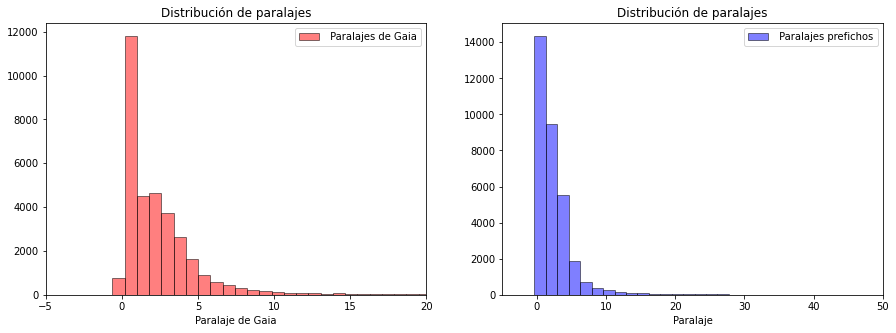

In [25]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.hist(Y_test , bins = 100, alpha=0.5, color = 'r', edgecolor='k', 
         label =f' Paralajes de Gaia')
plt.xlabel('Paralaje de Gaia')
plt.xlim(-5 , 20)
plt.title('Distribución de paralajes')
plt.legend()


plt.subplot(1,2,2)
plt.hist(Y_test_predict , bins = 1500, alpha=0.5, color = 'b', edgecolor='k', 
         label =f' Paralajes prefichos')

plt.xlabel('Paralaje')
plt.xlim(-5 , 50)
plt.title('Distribución de paralajes')
plt.legend()
plt.show()

### Evaluación según Sigma^MAD

In [16]:
def MAD(Y,Y_hat):  #USADA POR BOBY, astropy.stats.mad_std
    R_percent = (Y - Y_hat) / Y *100
    s_mad = 1.4826 * np.median(np.abs(R_percent - np.median(R_percent)))
    return s_mad

In [18]:
Y_hat_m7_snr_0_20 = model_7.predict([X_test_snr_0_20,K_mag_test_snr_0_20,X_offset_test_snr_0_20])
Y_hat_m7_snr_20_40 = model_7.predict([X_test_snr_20_40,K_mag_test_snr_20_40,X_offset_test_snr_20_40])
Y_hat_m7_snr_0_40 = model_7.predict([X_test_snr_0_40,K_mag_test_snr_0_40,X_offset_test_snr_0_40])
Y_hat_m7_snr_40_60 = model_7.predict([X_test_snr_40_60,K_mag_test_snr_40_60,X_offset_test_snr_40_60])
Y_hat_m7_snr_60_80 = model_7.predict([X_test_snr_60_80,K_mag_test_snr_60_80,X_offset_test_snr_60_80])
Y_hat_m7_snr_80_100 = model_7.predict([X_test_snr_80_100,K_mag_test_snr_80_100,X_offset_test_snr_80_100])
Y_hat_m7_snr_100_120 = model_7.predict([X_test_snr_100_120,K_mag_test_snr_100_120,X_offset_test_snr_100_120])
Y_hat_m7_snr_120_140 = model_7.predict([X_test_snr_120_140,K_mag_test_snr_120_140,X_offset_test_snr_120_140])
Y_hat_m7_snr_140_160 = model_7.predict([X_test_snr_140_160,K_mag_test_snr_140_160,X_offset_test_snr_140_160])
Y_hat_m7_snr_160_180 = model_7.predict([X_test_snr_160_180,K_mag_test_snr_160_180,X_offset_test_snr_160_180])
Y_hat_m7_snr_180_200 = model_7.predict([X_test_snr_180_200,K_mag_test_snr_180_200,X_offset_test_snr_180_200])

mad_m7_snr_0_20 = MAD(Y_test_snr_0_20, Y_hat_m7_snr_0_20)
mad_m7_snr_20_40 = MAD(Y_test_snr_20_40, Y_hat_m7_snr_20_40)
mad_m7_snr_0_40 = MAD(Y_test_snr_0_40, Y_hat_m7_snr_0_40)
mad_m7_snr_40_60 = MAD(Y_test_snr_40_60, Y_hat_m7_snr_40_60)
mad_m7_snr_60_80 = MAD(Y_test_snr_60_80, Y_hat_m7_snr_60_80)
mad_m7_snr_80_100 = MAD(Y_test_snr_80_100, Y_hat_m7_snr_80_100)
mad_m7_snr_100_120 = MAD(Y_test_snr_100_120, Y_hat_m7_snr_100_120)
mad_m7_snr_120_140 = MAD(Y_test_snr_120_140, Y_hat_m7_snr_120_140)
mad_m7_snr_140_160 = MAD(Y_test_snr_140_160, Y_hat_m7_snr_140_160)
mad_m7_snr_160_180 = MAD(Y_test_snr_160_180, Y_hat_m7_snr_160_180)
mad_m7_snr_180_200 = MAD(Y_test_snr_180_200, Y_hat_m7_snr_180_200)

mad_test_m7_snr_1 = [mad_m7_snr_0_20, mad_m7_snr_20_40, mad_m7_snr_40_60, mad_m7_snr_60_80, mad_m7_snr_80_100, 
                   mad_m7_snr_100_120,mad_m7_snr_120_140,mad_m7_snr_140_160,mad_m7_snr_160_180,mad_m7_snr_180_200]

mad_test_m7_snr_2 = [mad_m7_snr_0_40, mad_m7_snr_40_60, mad_m7_snr_60_80, mad_m7_snr_80_100, 
                   mad_m7_snr_100_120,mad_m7_snr_120_140,mad_m7_snr_140_160,mad_m7_snr_160_180,mad_m7_snr_180_200]


print("mad's modelo 7 con 10 bins: ", mad_test_m7_snr_1) 
print("mad's modelo 7 con 9 bins: ", mad_test_m7_snr_2) 

mad's modelo 7 con 10 bins:  [35.94688374370181, 29.113628020172534, 24.981631877076683, 18.82581353221038, 15.960550782404919, 14.52502338865755, 14.247969797965363, 13.092836970735034, 12.199149975903415, 12.100224293666203]
mad's modelo 7 con 9 bins:  [32.04085361800506, 24.981631877076683, 18.82581353221038, 15.960550782404919, 14.52502338865755, 14.247969797965363, 13.092836970735034, 12.199149975903415, 12.100224293666203]


In [19]:
Y_hat_m6_snr_0_20 = model_6.predict([X_test_snr_0_20,K_mag_test_snr_0_20,X_offset_test_snr_0_20])
Y_hat_m6_snr_20_40 = model_6.predict([X_test_snr_20_40,K_mag_test_snr_20_40,X_offset_test_snr_20_40])
Y_hat_m6_snr_0_40 = model_6.predict([X_test_snr_0_40,K_mag_test_snr_0_40,X_offset_test_snr_0_40])
Y_hat_m6_snr_40_60 = model_6.predict([X_test_snr_40_60,K_mag_test_snr_40_60,X_offset_test_snr_40_60])
Y_hat_m6_snr_60_80 = model_6.predict([X_test_snr_60_80,K_mag_test_snr_60_80,X_offset_test_snr_60_80])
Y_hat_m6_snr_80_100 = model_6.predict([X_test_snr_80_100,K_mag_test_snr_80_100,X_offset_test_snr_80_100])
Y_hat_m6_snr_100_120 = model_6.predict([X_test_snr_100_120,K_mag_test_snr_100_120,X_offset_test_snr_100_120])
Y_hat_m6_snr_120_140 = model_6.predict([X_test_snr_120_140,K_mag_test_snr_120_140,X_offset_test_snr_120_140])
Y_hat_m6_snr_140_160 = model_6.predict([X_test_snr_140_160,K_mag_test_snr_140_160,X_offset_test_snr_140_160])
Y_hat_m6_snr_160_180 = model_6.predict([X_test_snr_160_180,K_mag_test_snr_160_180,X_offset_test_snr_160_180])
Y_hat_m6_snr_180_200 = model_6.predict([X_test_snr_180_200,K_mag_test_snr_180_200,X_offset_test_snr_180_200])

mad_m6_snr_0_20 = MAD(Y_test_snr_0_20, Y_hat_m6_snr_0_20)
mad_m6_snr_20_40 = MAD(Y_test_snr_20_40, Y_hat_m6_snr_20_40)
mad_m6_snr_0_40 = MAD(Y_test_snr_0_40, Y_hat_m6_snr_0_40)
mad_m6_snr_40_60 = MAD(Y_test_snr_40_60, Y_hat_m6_snr_40_60)
mad_m6_snr_60_80 = MAD(Y_test_snr_60_80, Y_hat_m6_snr_60_80)
mad_m6_snr_80_100 = MAD(Y_test_snr_80_100, Y_hat_m6_snr_80_100)
mad_m6_snr_100_120 = MAD(Y_test_snr_100_120, Y_hat_m6_snr_100_120)
mad_m6_snr_120_140 = MAD(Y_test_snr_120_140, Y_hat_m6_snr_120_140)
mad_m6_snr_140_160 = MAD(Y_test_snr_140_160, Y_hat_m6_snr_140_160)
mad_m6_snr_160_180 = MAD(Y_test_snr_160_180, Y_hat_m6_snr_160_180)
mad_m6_snr_180_200 = MAD(Y_test_snr_180_200, Y_hat_m6_snr_180_200)

mad_test_m6_snr_1 = [mad_m6_snr_0_20, mad_m6_snr_20_40, mad_m6_snr_40_60, mad_m6_snr_60_80, mad_m6_snr_80_100, 
                   mad_m6_snr_100_120,mad_m6_snr_120_140,mad_m6_snr_140_160,mad_m6_snr_160_180,mad_m6_snr_180_200]

mad_test_m6_snr_2 = [mad_m6_snr_0_40, mad_m6_snr_40_60, mad_m6_snr_60_80, mad_m6_snr_80_100, 
                   mad_m6_snr_100_120,mad_m6_snr_120_140,mad_m6_snr_140_160,mad_m6_snr_160_180,mad_m6_snr_180_200]

print("mad's modelo 6 con 10 bins: ", mad_test_m6_snr_1) 
print("mad's modelo 6 con 9 bins: ", mad_test_m6_snr_2) 

mad's modelo 6 con 10 bins:  [66.80165751337029, 44.91433949057575, 32.46415104037084, 23.476516517208495, 18.000997108229864, 16.224914976943502, 14.888098245213186, 13.398874577193054, 12.519724662235992, 11.595007156965597]
mad's modelo 6 con 9 bins:  [47.776290612309126, 32.46415104037084, 23.476516517208495, 18.000997108229864, 16.224914976943502, 14.888098245213186, 13.398874577193054, 12.519724662235992, 11.595007156965597]


In [21]:
Y_hat_m5_snr_0_20 = model_5.predict([X_test_snr_0_20,K_mag_test_snr_0_20,X_offset_test_snr_0_20])
Y_hat_m5_snr_20_40 = model_5.predict([X_test_snr_20_40,K_mag_test_snr_20_40,X_offset_test_snr_20_40])
Y_hat_m5_snr_0_40 = model_5.predict([X_test_snr_0_40,K_mag_test_snr_0_40,X_offset_test_snr_0_40])
Y_hat_m5_snr_40_60 = model_5.predict([X_test_snr_40_60,K_mag_test_snr_40_60,X_offset_test_snr_40_60])
Y_hat_m5_snr_60_80 = model_5.predict([X_test_snr_60_80,K_mag_test_snr_60_80,X_offset_test_snr_60_80])
Y_hat_m5_snr_80_100 = model_5.predict([X_test_snr_80_100,K_mag_test_snr_80_100,X_offset_test_snr_80_100])
Y_hat_m5_snr_100_120 = model_5.predict([X_test_snr_100_120,K_mag_test_snr_100_120,X_offset_test_snr_100_120])
Y_hat_m5_snr_120_140 = model_5.predict([X_test_snr_120_140,K_mag_test_snr_120_140,X_offset_test_snr_120_140])
Y_hat_m5_snr_140_160 = model_5.predict([X_test_snr_140_160,K_mag_test_snr_140_160,X_offset_test_snr_140_160])
Y_hat_m5_snr_160_180 = model_5.predict([X_test_snr_160_180,K_mag_test_snr_160_180,X_offset_test_snr_160_180])
Y_hat_m5_snr_180_200 = model_5.predict([X_test_snr_180_200,K_mag_test_snr_180_200,X_offset_test_snr_180_200])

mad_m5_snr_0_20 = MAD(Y_test_snr_0_20, Y_hat_m5_snr_0_20)
mad_m5_snr_20_40 = MAD(Y_test_snr_20_40, Y_hat_m5_snr_20_40)
mad_m5_snr_0_40 = MAD(Y_test_snr_0_40, Y_hat_m5_snr_0_40)
mad_m5_snr_40_60 = MAD(Y_test_snr_40_60, Y_hat_m5_snr_40_60)
mad_m5_snr_60_80 = MAD(Y_test_snr_60_80, Y_hat_m5_snr_60_80)
mad_m5_snr_80_100 = MAD(Y_test_snr_80_100, Y_hat_m5_snr_80_100)
mad_m5_snr_100_120 = MAD(Y_test_snr_100_120, Y_hat_m5_snr_100_120)
mad_m5_snr_120_140 = MAD(Y_test_snr_120_140, Y_hat_m5_snr_120_140)
mad_m5_snr_140_160 = MAD(Y_test_snr_140_160, Y_hat_m5_snr_140_160)
mad_m5_snr_160_180 = MAD(Y_test_snr_160_180, Y_hat_m5_snr_160_180)
mad_m5_snr_180_200 = MAD(Y_test_snr_180_200, Y_hat_m5_snr_180_200)

mad_test_m5_snr_1 = [mad_m5_snr_0_20, mad_m5_snr_20_40, mad_m5_snr_40_60, mad_m5_snr_60_80, mad_m5_snr_80_100, 
                   mad_m5_snr_100_120,mad_m5_snr_120_140,mad_m5_snr_140_160,mad_m5_snr_160_180,mad_m5_snr_180_200]

mad_test_m5_snr_2 = [mad_m5_snr_0_40, mad_m5_snr_40_60, mad_m5_snr_60_80, mad_m5_snr_80_100, 
                   mad_m5_snr_100_120,mad_m5_snr_120_140,mad_m5_snr_140_160,mad_m5_snr_160_180,mad_m5_snr_180_200]

print("mad's modelo 5 con 10 bins: ", mad_test_m5_snr_1) 
print("mad's modelo 5 con 9 bins: ", mad_test_m5_snr_2) 

mad's modelo 5 con 10 bins:  [77.8832305928815, 53.09535647662746, 38.565102230497295, 28.428494321308868, 22.356377993627127, 20.1664097012893, 19.985412975680976, 17.755345371347563, 16.61350290826475, 16.190421812307125]
mad's modelo 5 con 9 bins:  [56.20707286251907, 38.565102230497295, 28.428494321308868, 22.356377993627127, 20.1664097012893, 19.985412975680976, 17.755345371347563, 16.61350290826475, 16.190421812307125]


In [22]:
Y_hat_m4_snr_0_20 = model_4.predict([X_test_snr_0_20,K_mag_test_snr_0_20,X_offset_test_snr_0_20])
Y_hat_m4_snr_20_40 = model_4.predict([X_test_snr_20_40,K_mag_test_snr_20_40,X_offset_test_snr_20_40])
Y_hat_m4_snr_0_40 = model_4.predict([X_test_snr_0_40,K_mag_test_snr_0_40,X_offset_test_snr_0_40])
Y_hat_m4_snr_40_60 = model_4.predict([X_test_snr_40_60,K_mag_test_snr_40_60,X_offset_test_snr_40_60])
Y_hat_m4_snr_60_80 = model_4.predict([X_test_snr_60_80,K_mag_test_snr_60_80,X_offset_test_snr_60_80])
Y_hat_m4_snr_80_100 = model_4.predict([X_test_snr_80_100,K_mag_test_snr_80_100,X_offset_test_snr_80_100])
Y_hat_m4_snr_100_120 = model_4.predict([X_test_snr_100_120,K_mag_test_snr_100_120,X_offset_test_snr_100_120])
Y_hat_m4_snr_120_140 = model_4.predict([X_test_snr_120_140,K_mag_test_snr_120_140,X_offset_test_snr_120_140])
Y_hat_m4_snr_140_160 = model_4.predict([X_test_snr_140_160,K_mag_test_snr_140_160,X_offset_test_snr_140_160])
Y_hat_m4_snr_160_180 = model_4.predict([X_test_snr_160_180,K_mag_test_snr_160_180,X_offset_test_snr_160_180])
Y_hat_m4_snr_180_200 = model_4.predict([X_test_snr_180_200,K_mag_test_snr_180_200,X_offset_test_snr_180_200])

mad_m4_snr_0_20 = MAD(Y_test_snr_0_20, Y_hat_m4_snr_0_20)
mad_m4_snr_20_40 = MAD(Y_test_snr_20_40, Y_hat_m4_snr_20_40)
mad_m4_snr_0_40 = MAD(Y_test_snr_0_40, Y_hat_m4_snr_0_40)
mad_m4_snr_40_60 = MAD(Y_test_snr_40_60, Y_hat_m4_snr_40_60)
mad_m4_snr_60_80 = MAD(Y_test_snr_60_80, Y_hat_m4_snr_60_80)
mad_m4_snr_80_100 = MAD(Y_test_snr_80_100, Y_hat_m4_snr_80_100)
mad_m4_snr_100_120 = MAD(Y_test_snr_100_120, Y_hat_m4_snr_100_120)
mad_m4_snr_120_140 = MAD(Y_test_snr_120_140, Y_hat_m4_snr_120_140)
mad_m4_snr_140_160 = MAD(Y_test_snr_140_160, Y_hat_m4_snr_140_160)
mad_m4_snr_160_180 = MAD(Y_test_snr_160_180, Y_hat_m4_snr_160_180)
mad_m4_snr_180_200 = MAD(Y_test_snr_180_200, Y_hat_m4_snr_180_200)

mad_test_m4_snr_1 = [mad_m4_snr_0_20, mad_m4_snr_20_40, mad_m4_snr_40_60, mad_m4_snr_60_80, mad_m4_snr_80_100, 
                   mad_m4_snr_100_120,mad_m4_snr_120_140,mad_m4_snr_140_160,mad_m4_snr_160_180,mad_m4_snr_180_200]

mad_test_m4_snr_2 = [mad_m4_snr_0_40, mad_m4_snr_40_60, mad_m4_snr_60_80, mad_m4_snr_80_100, 
                   mad_m4_snr_100_120,mad_m4_snr_120_140,mad_m4_snr_140_160,mad_m4_snr_160_180,mad_m4_snr_180_200]

print("mad's modelo 4 con 10 bins: ", mad_test_m4_snr_1) 
print("mad's modelo 4 con 9 bins: ", mad_test_m4_snr_2) 

mad's modelo 4 con 10 bins:  [77.54783854689387, 54.87321960184128, 43.127109235487744, 30.566586191607342, 24.755679875853335, 22.1514584114736, 21.580537410911386, 20.322889862057764, 19.210570335318817, 17.414268739616716]
mad's modelo 4 con 9 bins:  [59.06537398921217, 43.127109235487744, 30.566586191607342, 24.755679875853335, 22.1514584114736, 21.580537410911386, 20.322889862057764, 19.210570335318817, 17.414268739616716]


In [23]:
Y_hat_m3_snr_0_20 = model_3.predict([X_test_snr_0_20,K_mag_test_snr_0_20,X_offset_test_snr_0_20])
Y_hat_m3_snr_20_40 = model_3.predict([X_test_snr_20_40,K_mag_test_snr_20_40,X_offset_test_snr_20_40])
Y_hat_m3_snr_0_40 = model_3.predict([X_test_snr_0_40,K_mag_test_snr_0_40,X_offset_test_snr_0_40])
Y_hat_m3_snr_40_60 = model_3.predict([X_test_snr_40_60,K_mag_test_snr_40_60,X_offset_test_snr_40_60])
Y_hat_m3_snr_60_80 = model_3.predict([X_test_snr_60_80,K_mag_test_snr_60_80,X_offset_test_snr_60_80])
Y_hat_m3_snr_80_100 = model_3.predict([X_test_snr_80_100,K_mag_test_snr_80_100,X_offset_test_snr_80_100])
Y_hat_m3_snr_100_120 = model_3.predict([X_test_snr_100_120,K_mag_test_snr_100_120,X_offset_test_snr_100_120])
Y_hat_m3_snr_120_140 = model_3.predict([X_test_snr_120_140,K_mag_test_snr_120_140,X_offset_test_snr_120_140])
Y_hat_m3_snr_140_160 = model_3.predict([X_test_snr_140_160,K_mag_test_snr_140_160,X_offset_test_snr_140_160])
Y_hat_m3_snr_160_180 = model_3.predict([X_test_snr_160_180,K_mag_test_snr_160_180,X_offset_test_snr_160_180])
Y_hat_m3_snr_180_200 = model_3.predict([X_test_snr_180_200,K_mag_test_snr_180_200,X_offset_test_snr_180_200])

mad_m3_snr_0_20 = MAD(Y_test_snr_0_20, Y_hat_m3_snr_0_20)
mad_m3_snr_20_40 = MAD(Y_test_snr_20_40, Y_hat_m3_snr_20_40)
mad_m3_snr_0_40 = MAD(Y_test_snr_0_40, Y_hat_m3_snr_0_40)
mad_m3_snr_40_60 = MAD(Y_test_snr_40_60, Y_hat_m3_snr_40_60)
mad_m3_snr_60_80 = MAD(Y_test_snr_60_80, Y_hat_m3_snr_60_80)
mad_m3_snr_80_100 = MAD(Y_test_snr_80_100, Y_hat_m3_snr_80_100)
mad_m3_snr_100_120 = MAD(Y_test_snr_100_120, Y_hat_m3_snr_100_120)
mad_m3_snr_120_140 = MAD(Y_test_snr_120_140, Y_hat_m3_snr_120_140)
mad_m3_snr_140_160 = MAD(Y_test_snr_140_160, Y_hat_m3_snr_140_160)
mad_m3_snr_160_180 = MAD(Y_test_snr_160_180, Y_hat_m3_snr_160_180)
mad_m3_snr_180_200 = MAD(Y_test_snr_180_200, Y_hat_m3_snr_180_200)

mad_test_m3_snr_1 = [mad_m3_snr_0_20, mad_m3_snr_20_40, mad_m3_snr_40_60, mad_m3_snr_60_80, mad_m3_snr_80_100, 
                   mad_m3_snr_100_120,mad_m3_snr_120_140,mad_m3_snr_140_160,mad_m3_snr_160_180,mad_m3_snr_180_200]

mad_test_m3_snr_2 = [mad_m3_snr_0_40, mad_m3_snr_40_60, mad_m3_snr_60_80, mad_m3_snr_80_100, 
                   mad_m3_snr_100_120,mad_m3_snr_120_140,mad_m3_snr_140_160,mad_m3_snr_160_180,mad_m3_snr_180_200]

print("mad's modelo 3 con 10 bins: ", mad_test_m3_snr_1) 
print("mad's modelo 3 con 9 bins: ", mad_test_m3_snr_2) 

mad's modelo 3 con 10 bins:  [76.49440587288973, 62.7858911533974, 53.539532822405675, 35.46103115464739, 29.271794455877654, 26.55986712068683, 26.0592903367057, 25.088492741879275, 24.138559651861605, 22.962008244258744]
mad's modelo 3 con 9 bins:  [66.77951027962241, 53.539532822405675, 35.46103115464739, 29.271794455877654, 26.55986712068683, 26.0592903367057, 25.088492741879275, 24.138559651861605, 22.962008244258744]


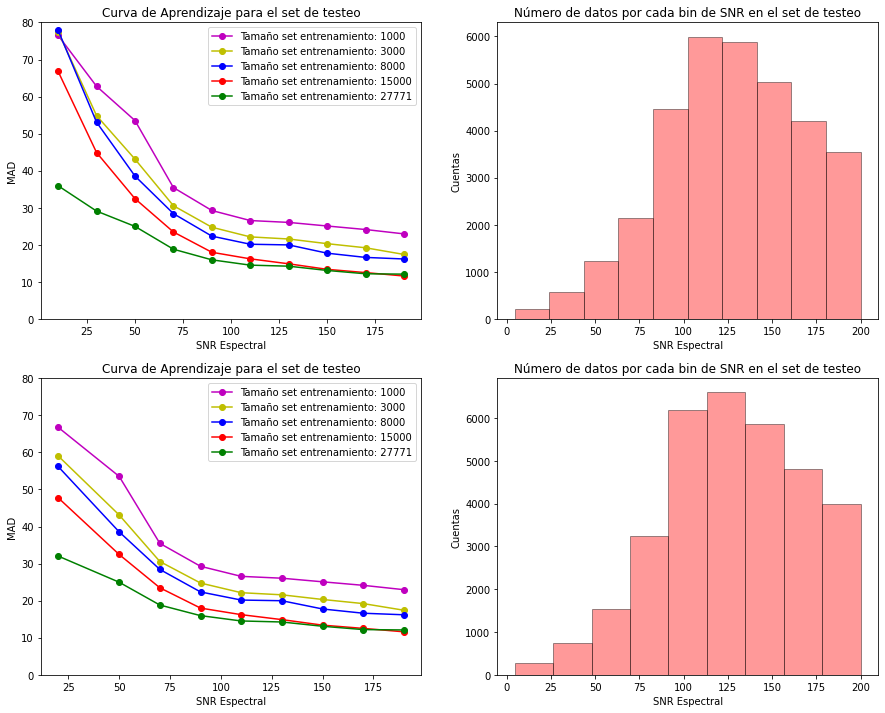

In [27]:
snr_list_1 = [10, 30 , 50 , 70 , 90 , 110 , 130 , 150 , 170 , 190]

snr_list_2 = [20 , 50 , 70 , 90 , 110 , 130 , 150 , 170 , 190]

plt.figure(figsize = (15,12))
plt.subplot(2,2,1)
plt.plot(snr_list_1, mad_test_m3_snr_1, "om-", label = "Tamaño set entrenamiento: 1000")
plt.plot(snr_list_1, mad_test_m4_snr_1, "oy-", label = "Tamaño set entrenamiento: 3000")
plt.plot(snr_list_1, mad_test_m5_snr_1, "ob-", label = "Tamaño set entrenamiento: 8000")
plt.plot(snr_list_1, mad_test_m6_snr_1, "or-", label = "Tamaño set entrenamiento: 15000")
plt.plot(snr_list_1, mad_test_m7_snr_1, "og-", label = "Tamaño set entrenamiento: 27771")
plt.legend(loc= "upper right", bbox_to_anchor=(1, 1))
plt.ylabel("MAD")
#plt.yscale("log")
plt.xlabel("SNR Espectral")
plt.title("Curva de Aprendizaje para el set de testeo")
plt.ylim(0,80)


plt.subplot(2,2,2)
plt.hist(snr_test, bins=10, alpha=0.4 , color="r",edgecolor='k')
#plt.xlim([-500, 500])
plt.xlabel('SNR Espectral')
plt.ylabel('Cuentas')
plt.title('Número de datos por cada bin de SNR en el set de testeo')


plt.subplot(2,2,3)
plt.plot(snr_list_2, mad_test_m3_snr_2, "om-", label = "Tamaño set entrenamiento: 1000")
plt.plot(snr_list_2, mad_test_m4_snr_2, "oy-", label = "Tamaño set entrenamiento: 3000")
plt.plot(snr_list_2, mad_test_m5_snr_2, "ob-", label = "Tamaño set entrenamiento: 8000")
plt.plot(snr_list_2, mad_test_m6_snr_2, "or-", label = "Tamaño set entrenamiento: 15000")
plt.plot(snr_list_2, mad_test_m7_snr_2, "og-", label = "Tamaño set entrenamiento: 27771")
plt.legend(loc= "upper right", bbox_to_anchor=(1, 1))
plt.ylabel("MAD")
#plt.yscale("log")
plt.xlabel("SNR Espectral")
plt.title("Curva de Aprendizaje para el set de testeo")
plt.ylim(0,80)


plt.subplot(2,2,4)
plt.hist(snr_test, bins=9, alpha=0.4 , color="r",edgecolor='k')
#plt.xlim([-500, 500])
plt.xlabel('SNR Espectral')
plt.ylabel('Cuentas')
plt.title('Número de datos por cada bin de SNR en el set de testeo')
plt.show()